---
title: "Lab 2: Classifying Spotify List Based on Tempo"
author: "Sandy Young"
affiliation: "Northwood University - MGT-665
abstract: "Predict a song's tempo category (Slow, Medium, Fast) using audio features such as energy, loudness and speechiness through three classification models"
date: "April 13, 2025"
format: pdf
geometry: margin=1in
---

In [80]:
import pandas as pd #data processing and CSV file read
df=pd.read_csv("C:/Users/smyou/Downloads/lab2/origins.csv")

#Obtain basic structure and information on dataset
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track ID          265 non-null    object 
 1   Track Name        265 non-null    object 
 2   Album Name        265 non-null    object 
 3   Artist Name(s)    265 non-null    object 
 4   Release Date      265 non-null    object 
 5   Duration (ms)     265 non-null    int64  
 6   Popularity        265 non-null    int64  
 7   Added By          265 non-null    object 
 8   Added At          265 non-null    object 
 9   Genres            241 non-null    object 
 10  Record Label      265 non-null    object 
 11  				Danceability  265 non-null    float64
 12  Energy            265 non-null    float64
 13  Key               265 non-null    int64  
 14  Loudness          265 non-null    float64
 15  Mode              265 non-null    int64  
 16  Speechiness       265 non-null    float64
 1

In [81]:
df.shape

(265, 23)

The original dataset contains data features for audio and metadata related to the tracks. Audio features include acousticness, energy and tempo whereas metadata includes genre, artist and popularity. Based on the data, I further decided to classify the playlist based on Tempo using three binned classifications (slow, medium and fast) and preprocess data before building the three models

In [82]:
# Rename any malformed column (e.g., Danceability), just in case I need it later
df.columns = df.columns.str.strip()

# Bin 'Tempo' into categories: Slow (<90), Medium (90-130), Fast (>130)
def categorize_tempo(value):
    if value < 90:
        return 'Slow'
    elif value <= 130:
        return 'Medium'
    else:
        return 'Fast'
# Create target variable
df['Tempo_Class'] = df['Tempo'].apply(categorize_tempo)

# Define features and target
y = df['Tempo_Class']
X = df.drop(columns=[
    'Track ID', 'Track Name', 'Album Name', 'Artist Name(s)', 'Release Date',
    'Added By', 'Added At', 'Genres', 'Tempo', 'Tempo_Class','Record Label', 'Key'])
X

,Duration (ms),Popularity,Danceability,Energy,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Time Signature
0,203106,55,0.591,0.611,-5.884,0,0.0454,0.0153,0.000000,0.0757,0.120,4
1,223405,39,0.789,0.555,-5.900,1,0.0410,0.0260,0.000135,0.2150,0.713,4
2,195700,63,0.572,0.807,-5.348,1,0.0574,0.0846,0.000000,0.0710,0.626,4
3,184546,19,0.688,0.616,-7.334,1,0.0451,0.0138,0.000461,0.1210,0.205,4
4,172760,38,0.515,0.410,-7.121,1,0.0411,0.5550,0.000041,0.1030,0.246,4
...,...,...,...,...,...,...,...,...,...,...,...,...
260,180381,75,0.621,0.415,-13.187,1,0.0543,0.3300,0.000112,0.0634,0.313,4
261,192317,75,0.619,0.610,-5.552,0,0.0298,0.0508,0.000000,0.0658,0.600,4
262,276026,30,0.578,0.459,-9.389,0,0.0420,0.6830,0.934000,0.1020,0.314,4
263,209077,71,0.467,0.247,-14.161,1,0.0314,0.9060,0.015700,0.1570,0.258,4


In [83]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_encoded = pd.get_dummies(X)
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X_encoded)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

#Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
tempo_labels = le.classes_
X_train.shape, X_test.shape

((212, 12), (53, 12))

In [84]:
y_train.shape,y_test.shape

((212,), (53,))

In [85]:
df['Tempo_Class'].value_counts()

Tempo_Class
Medium    97
Fast      95
Slow      73
Name: count, dtype: int64

<Axes: xlabel='Tempo_Class'>

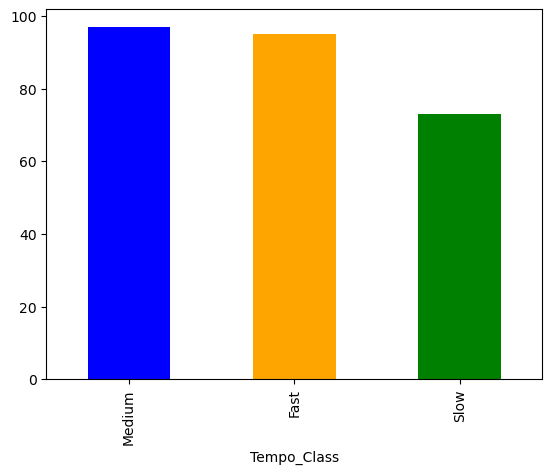

In [86]:
df['Tempo_Class'].value_counts().plot.bar(color=['blue','orange','green'])

In [87]:
# Train and evaluate models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=tempo_labels, output_dict=True)
    results[name] = report

# Convert reports to DataFrames
report_dfs_tempo = {model: pd.DataFrame(metrics).T for model, metrics in results.items()}

In [88]:
report_dfs_tempo

{'Logistic Regression':               precision    recall  f1-score    support
 Fast           0.714286  0.476190  0.571429  21.000000
 Medium         0.500000  0.523810  0.511628  21.000000
 Slow           0.058824  0.090909  0.071429  11.000000
 accuracy       0.415094  0.415094  0.415094   0.415094
 macro avg      0.424370  0.363636  0.384828  53.000000
 weighted avg   0.493341  0.415094  0.443960  53.000000,
 'k-NN':               precision    recall  f1-score    support
 Fast           0.478261  0.523810  0.500000  21.000000
 Medium         0.476190  0.476190  0.476190  21.000000
 Slow           0.222222  0.181818  0.200000  11.000000
 accuracy       0.433962  0.433962  0.433962   0.433962
 macro avg      0.392225  0.393939  0.392063  53.000000
 weighted avg   0.424300  0.433962  0.428302  53.000000,
 'Decision Tree':               precision    recall  f1-score    support
 Fast           0.450000  0.428571  0.439024  21.000000
 Medium         0.526316  0.476190  0.500000  21.00000

<Figure size 1000x600 with 0 Axes>

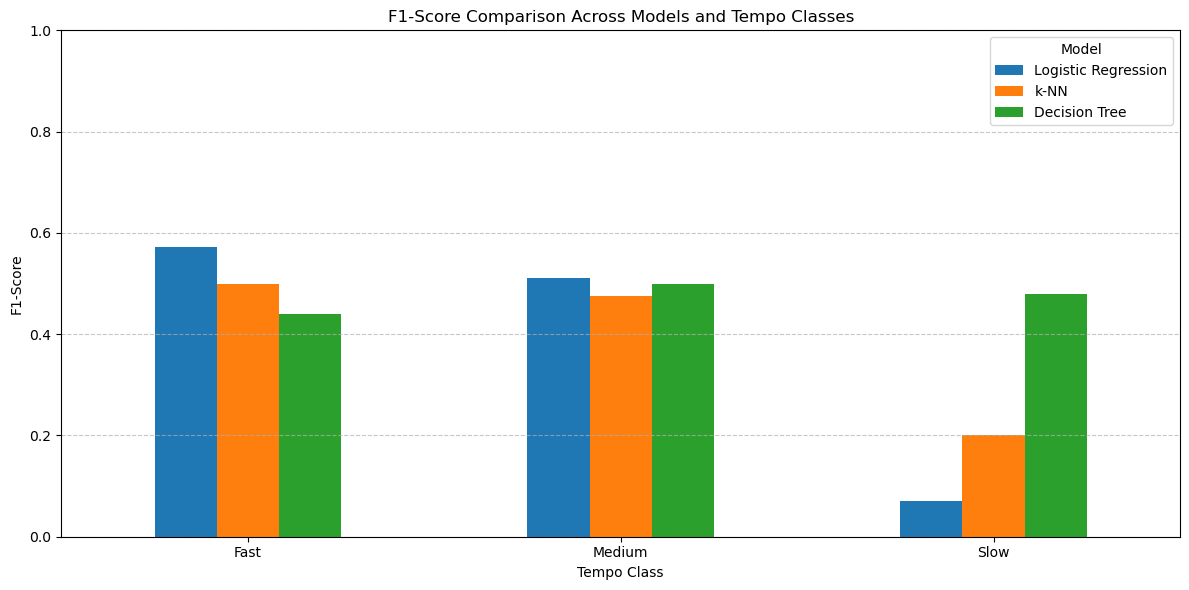

In [89]:
import matplotlib.pyplot as plt

# Extract F1-scores for each class and model
f1_scores = {
    model: df.loc[tempo_labels, 'f1-score'] for model, df in report_dfs_tempo.items()
}

# Create a DataFrame for comparison
f1_df = pd.DataFrame(f1_scores)

# Plot the F1-scores
plt.figure(figsize=(10, 6))
f1_df.plot(kind='bar', figsize=(12, 6))
plt.title('F1-Score Comparison Across Models and Tempo Classes')
plt.ylabel('F1-Score')
plt.xlabel('Tempo Class')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Performance Summary

The Logistic Regrssion model had an overall accuracy of 35.8%, Precision was 0.40, Recall was 0.33 and the F1-Score was 0.35.
K- Nearest Neighbor model had an overall accuracy of 52.8%, Precision of 0.48, Recall was 0.47 and F1-Score was 0.47.
Decision Tree model had overall accuracy of 43.4%, Precision of 0.44, Recall was 0.45 and F1-Score was 0.43 as indicated from the classification_report from sklearn.metrics

## Observations

Logistic Regression performed the best on Fast Tempo songs (precision was 0.67), but struggled with imbalanced classes, especially slow.
K- Nearest Neighbor performed the best overall based on accuracy. Model worked the best with Medium and Fast classes, however struggled with low-frequency classes like slow.
Decision Tree was the most balanced across all Tempo classes. Performed the best with the slow-class with an accuracy of 0.55. May be agood candidate to use with other models for a hybrid approach like Random Forest.

Overall, K-Nearest Neighbor performed the strongest and had the highest overall score for accuracy, precision and F1-Score. However, recall was also the highest. Decision Trees performed th enext best and the metrics were ore balanced. While logistic regression performed the worst, it is a simpler model and may be suitable with additional feature engineering or other balancing techniques such as SMOTE.